goal:

- use librosa on 1000 audio files and/or 50 class folders minimum
- store information in a dataframe (excluding actual file data for now)
  - folder name, file name, sampling rate, data length, file length, file size(?)

In [1]:
import pandas as pd
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchaudio
import copy
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

from tqdm import tqdm
from IPython.display import Audio

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from imblearn.over_sampling import RandomOverSampler

from math import floor

torch.set_printoptions(sci_mode=False)

In [2]:
# experimental parameters for model training, for simple configuration in a single cell.
# very useful for reporting spreadsheet

folder_key = {}

split_interval_secs = 3
split_length = 10000000000000 # absurd number for future use
sample_rate = 32000

variance_threshold = 0.2
mean_threshold = 5

total_folders = 10
min_rating = 5.0
max_files_per_folder = 0

sampling_technique = "median"

test_size = 0.2

epochs = 50
batch_size = 1024
dropout_rate = 0.5
learning_rate = 0.001
momentum = 0
experimental = False
experimental_counter_limit = 10
save_best_to_file = False

In [3]:
def reset_seed():
    torch.manual_seed(1368)
    random.seed(1368)
    np.random.seed(1368)

reset_seed()

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for i in range(torch.cuda.device_count()):
   print(torch.cuda.get_device_properties(i).total_memory)

print(device)
print(torch.cuda.get_device_name())

8546353152
cuda
NVIDIA GeForce RTX 5060


In [5]:
# base_dir: directory of all the audio file folders
# split_interval_secs: the length of each sound clip when split up in a file.
#   - final dataframe will not contain any sound clips over/under this length
# sample_rate: sample rate of sound clips in hz
# total_folders: total folders to iterate through the files, given range of files per folder
# min_files_per_folder: minimum files to exist in the folder
# max_files_per_folder: maximum files to use inside the folder
def get_random_folders_filtered(base_dir: str, split_interval_secs: float, sample_rate: int = 32000, total_folders: int = 50, max_files_per_folder: int = -1, min_rating: float = 4.0):
    global split_length, folder_key

    # get the list of valid folders and files to analyse
    folder_key = {}

    folders = []
    valid_folders = set()
    valid_files = set([l.replace("\n", "") for l in open(f"rating_thresholds_at_least_10_classes/min_rating_{int(min_rating * 2)}.txt").readlines()])
    for f in valid_files: valid_folders.add(f.split("/")[0])
    for folder in [line.replace("\n", "") for line in open("folder_order.txt").readlines()]:
        if folder in valid_folders:
            folders.append(folder)

    folder_count = 0

    # if there are less folders than those specified, view all folders instead of given amount
    total_folders = min(len(folders), total_folders)

    rows = []
    
    for folder in folders:
        
        folder_path = base_dir + folder + "/"
        valid_folder_files = []
        # only iterate through the valid audio files
        for file in os.listdir(folder_path):
            if folder + "/" + file in valid_files:
                valid_folder_files.append(folder_path + file)
        random.shuffle(valid_folder_files)

        if max_files_per_folder > 0:
            valid_folder_files = valid_folder_files[:min(max_files_per_folder, len(valid_folder_files))]

        # iterate through each file in the folder
        for file_path in (progress_bar := tqdm(valid_folder_files)):
            # load file data and resample to sample_rate if necessary
            file_data, file_sample_rate_hz = torchaudio.load(uri=file_path, channels_first=True)
            if file_sample_rate_hz != sample_rate:
                file_data = torchaudio.functional.resample(file_data, orig_freq=file_sample_rate_hz, new_freq=sample_rate)

            # convert all audio into mono (1 channel) if audio is stereo (2 channels)
            if file_data.shape[0] == 2:
                file_data = file_data.mean(dim=0)
            else:
                file_data = file_data.flatten()

            # get total number of X second splits
            total_splits = floor(len(file_data) / int(sample_rate * split_interval_secs))
            
            # convert file data into mel-spectrogram fourier transform for feeding into CNN
            n_fft = 1024

            mel_spec_transform = torchaudio.transforms.MelSpectrogram(sample_rate = sample_rate, power=2, n_fft=n_fft)
            amp_to_db_transform = torchaudio.transforms.AmplitudeToDB(stype="amplitude", top_db=80)
            mel_spec_data_db = amp_to_db_transform(mel_spec_transform(file_data)).numpy()
            
            # if file is at least X seconds.
            if total_splits >= 1:
                split_length = min(mel_spec_data_db.shape[1] // total_splits, split_length)
                mel_spec_splits = np.arange(0, mel_spec_data_db.shape[1], split_length)
                for i in range(len(mel_spec_splits) - 1):
                    start = mel_spec_splits[i]
                    end = mel_spec_splits[i + 1]

                    mel_spec_split = mel_spec_data_db[:, start:end]

                    row = {}
                    row["folder"] = folder
                    row["file"] = file_path.split("/")[-1]
                    row["mel_spec"] = mel_spec_split
                    row["mel_spec_shape"] = mel_spec_split.shape

                    # determine and filter for "silence":
                    var = np.var(mel_spec_split)
                    # mean = torch.mean(mel_spec_split)

                    if not (var <= variance_threshold):
                        rows.append(row)

                folder_key[folder_count] = folder
            
            progress_bar.set_description(f"Folder {folder_count + 1}/{total_folders} - {folder}")
        
        # end loop if total_folders has been reached
        folder_count += 1
        if folder_count >= total_folders: break

    # trim the ends of some mel spectrograms because of stupid floating point nonsense
    for i, row in enumerate(rows):
        if row["mel_spec_shape"][1] != split_length:
            row["mel_spec"] = row["mel_spec"][:, :split_length]
            row["mel_spec_shape"] = row["mel_spec"].shape

    return pd.DataFrame(rows)

In [6]:
#base_dir = "/mnt/lustre/peprmint/train_audio/"
base_dir = "../../datasets/birdsongs-combined/train_audio/"

reset_seed()

folder_df = get_random_folders_filtered(
    base_dir, 
    split_interval_secs=split_interval_secs, 
    sample_rate=sample_rate,
    total_folders=total_folders,
    min_rating=min_rating,
    max_files_per_folder=max_files_per_folder
)

Folder 10/10 - brnjay: 100%|██████████| 23/23 [00:01<00:00, 22.88it/s]


In [7]:
folder_df.head()

,folder,file,mel_spec,mel_spec_shape
0,dowwoo,XC476564.ogg,"[[-20.433891, -20.433891, -20.433891, -20.4338...","(128, 187)"
1,dowwoo,XC476564.ogg,"[[-20.433891, -19.363777, -20.433891, -20.4338...","(128, 187)"
2,dowwoo,XC210867.ogg,"[[-15.447197, -15.447197, -15.447197, -15.4471...","(128, 187)"
3,dowwoo,XC210867.ogg,"[[-15.447197, -15.447197, -15.447197, -15.4471...","(128, 187)"
4,dowwoo,XC210867.ogg,"[[-15.447197, -15.447197, -15.447197, -15.4471...","(128, 187)"


In [8]:
folder_df["mel_spec_shape"].value_counts()

mel_spec_shape
(128, 187)    6161
Name: count, dtype: int64

In [9]:
folder_df["folder"].value_counts()

folder
barswa     3011
rerswa1     687
indbun      625
cobtan1     384
mitpar      323
brnjay      319
dowwoo      293
blhpar1     262
comloo      131
amepip      126
Name: count, dtype: int64

In [10]:
print("sound clips BEFORE any sampling:", len(folder_df))

sound clips BEFORE any sampling: 6161


In [11]:
len(folder_df["folder"].unique())

10

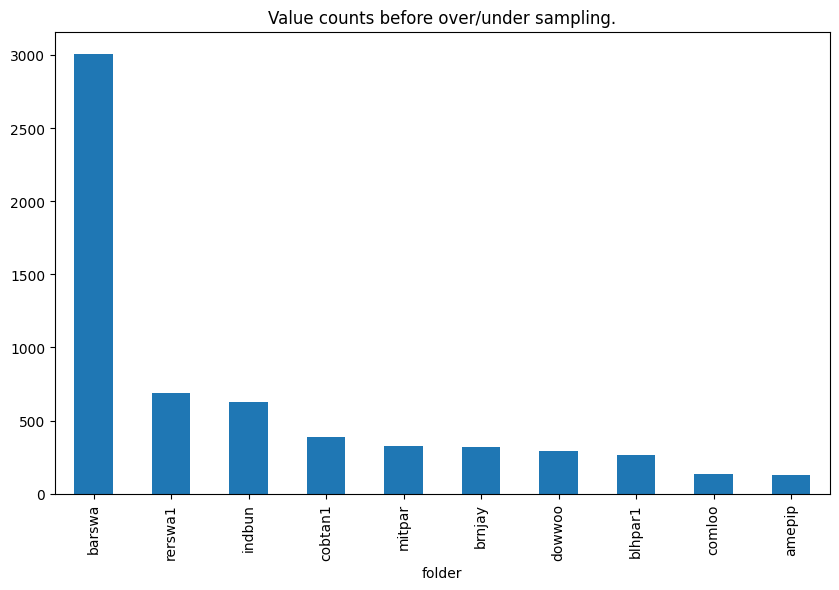

In [12]:
plt.figure(figsize=(max(10, total_folders // 8), 6))
folder_df["folder"].value_counts().plot.bar(title="Value counts before over/under sampling.")
plt.show()

In [13]:
# apply random undersampling OR oversampling

reset_seed()

if sampling_technique == "under":
    # random "naive" undersampling
    # delete random rows from all classes except minority class(es)
    min_folder_count = min(folder_df["folder"].value_counts())

    indices_to_keep = np.array([])

    for f in folder_df["folder"].unique():
        indices_to_keep = np.concat([np.random.choice(folder_df[folder_df["folder"] == f].index, size=min_folder_count), indices_to_keep])

    folder_df = folder_df.loc[indices_to_keep]
    folder_df.reset_index(drop=True, inplace=True)

if sampling_technique == "over":
    ros = RandomOverSampler(random_state=1368)

    # print how much each class will increase by (relative to its current size)
    max_folder = max(folder_df["folder"].value_counts())
    for folder, count in folder_df["folder"].value_counts().sort_values(ascending=True).items():
        print(f"{folder} will increase by {round((max_folder / count - 1) * 100, 2)}%")

    folder_df = pd.concat(ros.fit_resample(folder_df.drop("folder", axis=1), folder_df["folder"]), axis=1)
    # moves "folder" to other side of df but shouldn't affect anything

if sampling_technique == "median":
    # take the median value of folder counts
    # under sample all above the median
    # over smaple all below the median

    ros = RandomOverSampler(random_state=1368)
    median_folder_count = round(folder_df["folder"].value_counts().median())
    indices_to_keep = np.array([])

    print("median:", median_folder_count)

    for f in folder_df["folder"].unique():
        folder_length = len(folder_df[folder_df["folder"] == f])
        if folder_length > median_folder_count:
            indices_to_keep = np.concat([np.random.choice(folder_df[folder_df["folder"] == f].index, size=median_folder_count), indices_to_keep])
        else:
            indices_to_keep = np.concat([folder_df[folder_df["folder"] == f].index, indices_to_keep])
        
    folder_df = folder_df.loc[indices_to_keep]
    folder_df.reset_index(drop=True, inplace=True)
    
    folder_df = pd.concat(ros.fit_resample(folder_df.drop("folder", axis=1), folder_df["folder"]), axis=1)

median: 321


<Axes: title={'center': 'Value counts after median sampling.'}, xlabel='folder'>

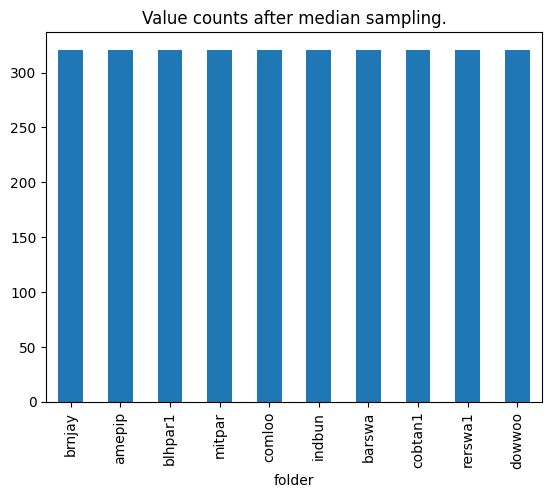

In [14]:
folder_df["folder"].value_counts().plot.bar(title=f"Value counts after {sampling_technique} sampling.")

In [15]:
print("sound clips AFTER sampling:", len(folder_df))

sound clips AFTER sampling: 3210


(128, 187)


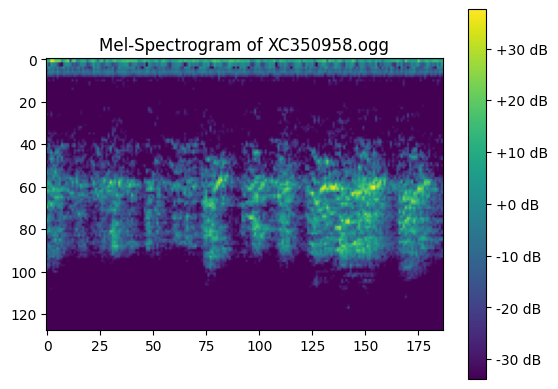

(128, 187)


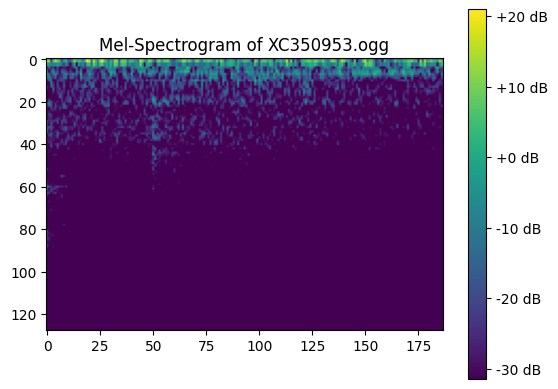

(128, 187)


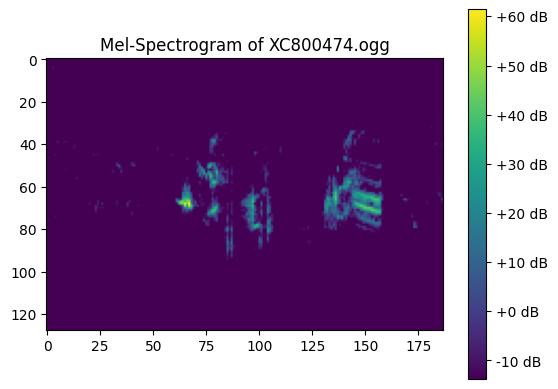

In [16]:
# plot 5 random mel spectrograms
# checks for consistency in scaling and whatnot

reset_seed()

sample_spec_indices = random.sample(folder_df.index.tolist(), k=3)

for i in sample_spec_indices:
    row = folder_df.iloc[i]
    
    print(row["mel_spec_shape"])
    
    plt.figure()
    plt.imshow(row["mel_spec"])
    plt.title(f"Mel-Spectrogram of {'/'.join(row['file'].split('/')[-2:])}")
    plt.colorbar(format='%+2.0f dB')
    plt.show()

del row

In [17]:
# input shape needs to be AxBxCxD
# A = list of files
# B = depth of each one (currently just 1, as it only contains 1 value. if colours are used then maybe up it to 3)
# CxD = input width/height (128x626 etc)
if "mel_spec" in folder_df.columns:
    print("step 1")
    x = folder_df["mel_spec"]
    print("step 2")
    folder_df.drop("mel_spec", axis=1, inplace=True)
    print("step 3")
    x = np.stack(x)
    print("step 4")
    x = torch.from_numpy(x)
    print("step 5")
    x = x.reshape(x.shape[0], 1, x.shape[1], x.shape[2])
    print("step 6")
    x = x.to(device)

print("step 7")
le = LabelEncoder()
print("step 8")
y = torch.LongTensor(le.fit_transform(folder_df["folder"]))
print("step 9")
y = y.to(device)

step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9


In [18]:
reset_seed()

x_train, x_test, y_train, y_test = train_test_split(x, y, shuffle=True, test_size=test_size, random_state=1368)

del x, y

In [19]:
# iteration 3.0

class TestModel(nn.Module):
    global folder_df

    def __init__(self, input_shape: torch.Size, dropout_rate: float = 0):
        super().__init__()

        total_output_classes = len(folder_df["folder"].unique())

        # input shape should be some list/tuple of length 4
        if len(input_shape) != 4: return Exception("Input shape is not AxBxCxD.")
        
        A = input_shape[0]
        B = input_shape[1]
        C = input_shape[2]
        D = input_shape[3]

        self.relu = nn.ReLU() # relu does not have trainable parameters, thus, can be reused

        self.conv1 = nn.Conv2d(in_channels=B, out_channels=10, kernel_size=(3, 3))
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.drop1 = nn.Dropout(p=dropout_rate)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3))
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.drop2 = nn.Dropout(p=dropout_rate)
        self.flat = nn.Flatten()

        flatten_nodes = 10 * ((((C - 2) // 2) - 2) // 2) * ((((D - 2) // 2) - 2) // 2)
        
        self.norm = nn.BatchNorm1d(num_features=flatten_nodes)
        self.linear1 = nn.Linear(in_features=flatten_nodes, out_features=1024)
        self.linear2 = nn.Linear(in_features=1024, out_features=512)
        self.linear3 = nn.Linear(in_features=512, out_features=128) 
        self.output = nn.Linear(in_features=128, out_features=total_output_classes)

    def forward(self, x):
        # define calculations here
        x = self.conv1(x)
        x = self.relu(x)

        x = self.pool1(x)
        x = self.drop1(x)

        x = self.conv2(x)
        x = self.relu(x)

        x = self.pool2(x)
        x = self.drop2(x)

        x = self.flat(x)
        x = self.norm(x)

        x = self.linear1(x)
        x = self.relu(x)

        x = self.linear2(x)
        x = self.relu(x)

        x = self.linear3(x)
        x = self.relu(x)

        x = self.output(x)
        x = self.relu(x)

        return x

In [20]:
# model: the model to train
# loss_fn: the loss function to update weights
# optimizer: the optimiser function to affect rate of change
# epochs: number of epochs to train the model over
# batch_size: samples to train x_train and y_train to avoid memory issues
# save_best_to_file: save model with highest test accuracy to models/ folder.
# experimental: whether to end training after 5 consecutive runs of no higher test accuracy.
#       - training ends when either [epochs] epochs have been run, *OR* if 5 consecutive runs do not improve test accuracy from previous best.

def train_model(model, loss_fn, optimizer, epochs, batch_size, save_best_to_file = False, experimental = False):
    global x_train, y_train
    batch_indices = np.linspace(0, len(x_train), int(len(x_train) / batch_size), dtype="int")

    train_loss_hist = []
    train_acc_hist = []
    test_acc_hist = []

    best_test_acc = 0
    best_model = None

    experimental_counter = 0

    for epoch in range(1, epochs + 1):
        model.train()

        train_acc = 0
        
        for i in range(len(batch_indices) - 1):
            start_index = batch_indices[i]
            stop_index = batch_indices[i + 1]

            x_batch = x_train[start_index:stop_index]
            y_batch = y_train[start_index:stop_index]

            x_batch, y_batch = shuffle(x_batch, y_batch)

            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)
            train_acc += sum(torch.argmax(y_pred, dim=1) == y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_acc = train_acc * 100 / len(y_train)

        model.eval()
        test_acc = sum(torch.argmax(model(x_test), dim=1) == y_test) * 100 / len(y_test)

        print(f"Epoch {epoch}: train loss = {loss:.04f}, train acc = {train_acc:.02f}%, test acc = {test_acc:.02f}% {"!!" if test_acc > best_test_acc else ""}")

        train_loss_hist.append(float(loss.cpu().detach().numpy()))
        train_acc_hist.append(float(train_acc.cpu().detach().numpy()))
        test_acc_hist.append(float(test_acc.cpu().detach().numpy()))

        if experimental:
            experimental_counter += 1

        if test_acc > best_test_acc:
            experimental_counter = 0
            best_test_acc = test_acc
            
            # overwrite best model with new best model
            best_model = copy.deepcopy(model.state_dict())

        if experimental_counter == experimental_counter_limit:
            print(f"Experimental Mode ended the training early, as the testing accuracy had not increased over {experimental_counter_limit} consecutive epochs.")
            break
        
    if save_best_to_file:
        model_save_path = "models/"
        if not os.path.exists(model_save_path): os.mkdir(model_save_path)
        file_number = len(os.listdir(model_save_path)) + 1
        file_name = f"best_model_{file_number:>03}"
        best_model_path = model_save_path + file_name + ".pth"

        torch.save(best_model, best_model_path)

    plt.figure(figsize=(12,8))
    pd.Series(train_acc_hist).plot.line(label="Train", color="blue")
    pd.Series(test_acc_hist).plot.line(label="Test", color="red")
    plt.legend()
    plt.ylim((0, 100))
    plt.yticks(np.arange(0, 101, 10))
    plt.title(f"Convolutional Neural Network on {len(folder_df)} sound clips over {len(folder_df["folder"].unique())} folders.")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.grid(axis="y")
    plt.show()

    return train_loss_hist, train_acc_hist, test_acc_hist, best_model

14444788
Epoch 1: train loss = 2.3049, train acc = 9.38%, test acc = 13.71% !!
Epoch 2: train loss = 2.2866, train acc = 20.02%, test acc = 24.92% !!
Epoch 3: train loss = 2.2331, train acc = 23.05%, test acc = 22.90% 
Epoch 4: train loss = 2.1864, train acc = 24.57%, test acc = 25.08% !!
Epoch 5: train loss = 2.1893, train acc = 27.14%, test acc = 22.12% 
Epoch 6: train loss = 2.1172, train acc = 29.13%, test acc = 24.45% 
Epoch 7: train loss = 2.0545, train acc = 31.97%, test acc = 26.79% !!
Epoch 8: train loss = 2.0152, train acc = 32.59%, test acc = 27.41% !!
Epoch 9: train loss = 1.9635, train acc = 35.79%, test acc = 28.04% !!
Epoch 10: train loss = 1.9202, train acc = 39.68%, test acc = 30.69% !!
Epoch 11: train loss = 1.8456, train acc = 42.06%, test acc = 32.09% !!
Epoch 12: train loss = 1.7787, train acc = 43.30%, test acc = 31.46% 
Epoch 13: train loss = 1.7339, train acc = 43.57%, test acc = 32.40% !!
Epoch 14: train loss = 1.6743, train acc = 48.33%, test acc = 29.75% 
Epo

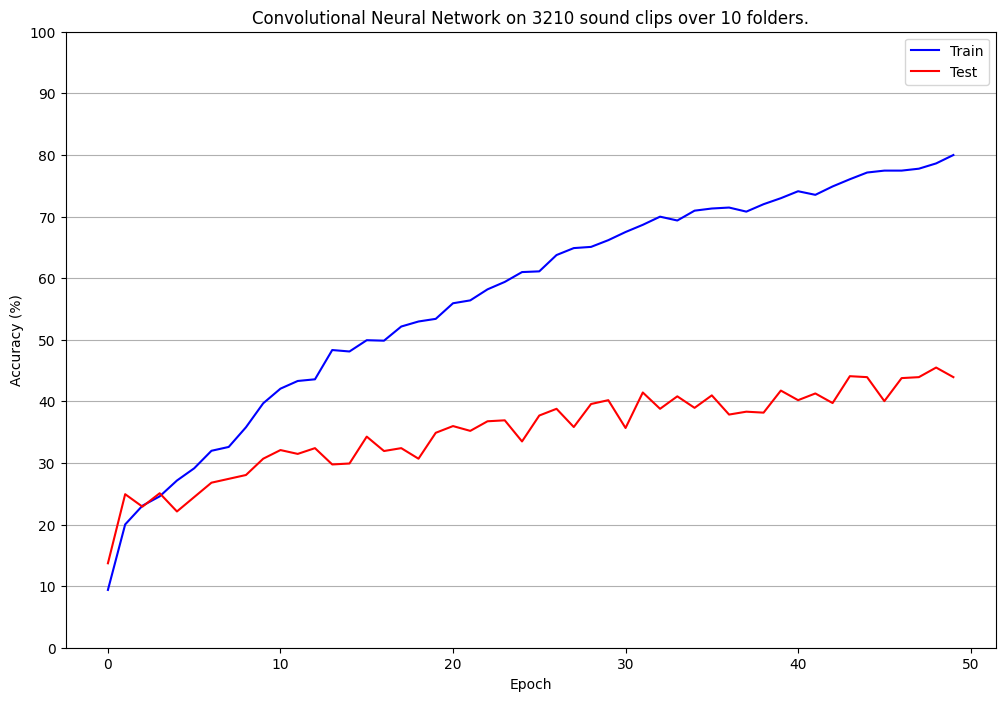

In [21]:
# to avoid extreme overfitting:
# - dropout rate between 0.2-0.5 seems good
# - learning rate around 0.001 provides best training rate without overfitting
# - train in larger batches, 64 upwards seems good
# - most seem to plateau around 200 epochs, maybe reduce to reduce total training time

reset_seed()

model = TestModel(input_shape=x_train.shape, dropout_rate=dropout_rate)
model = model.to(device)
loss_fn = nn.CrossEntropyLoss() # since we are classifying.
loss_fn = loss_fn.to(device)
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate) # adam has no momentum, but DOES have weight decay

print(sum(p.numel() for p in model.parameters() if p.requires_grad))

train_loss_hist, train_acc_hist, test_acc_hist, best_model = train_model(model, loss_fn, optimizer, epochs, batch_size, save_best_to_file=save_best_to_file, experimental=experimental)

In [22]:
# investigate TOP 5 ERROR of the model.
# compare with top 1 error (accuracy)

model.load_state_dict(best_model)
model.eval()

# get predictions for ALL testing data
k = 5
test_pred = model(x_test)
test_pred_top_k = torch.topk(test_pred, k=k, dim=1)[1]

total = 0
in_top_k = 0
for index, value in enumerate(y_test):
    if value in test_pred_top_k[index]: in_top_k += 1

    total += 1

top_k_accuracy = in_top_k * 100 / total

print(f"Top {k} Accuracy: {top_k_accuracy:.03f}%")

Top 5 Accuracy: 74.299%


In [23]:
folder_df["file"].value_counts()

file
XC350953.ogg    126
XC319994.ogg     97
XC189383.ogg     81
XC601771.ogg     80
XC350956.ogg     79
               ... 
XC794724.ogg      1
XC384434.ogg      1
XC755868.ogg      1
XC404415.mp3      1
XC298361.mp3      1
Name: count, Length: 370, dtype: int64

In [24]:
accuracy_df = pd.DataFrame(data=[y_test.cpu().numpy(), test_pred_top_k.cpu().numpy()], index=["actual", "pred"]).transpose()
accuracy_df["in_top_5"] = [1 if accuracy_df.iloc[i, 0] in accuracy_df.iloc[i, 1] else 0 for i in range(len(accuracy_df.index))]
folder_top_5 = accuracy_df.groupby(by="actual").aggregate(func=np.sum)["in_top_5"].values
folder_counts = accuracy_df.groupby(by="actual").aggregate(func=np.size)["in_top_5"].values
accuracy_df = pd.DataFrame(data=[folder_top_5, folder_counts], index=["in_top_5", "count"]).transpose()
accuracy_df["top_5_accuracy"] = round(accuracy_df["in_top_5"] * 100 / accuracy_df["count"], 2)
accuracy_df.sort_values(by="top_5_accuracy")

,in_top_5,count,top_5_accuracy
8,17,61,27.87
6,23,58,39.66
9,29,65,44.62
7,40,66,60.61
5,57,73,78.08
4,64,69,92.75
3,61,63,96.83
2,63,64,98.44
1,61,61,100.00
0,62,62,100.00


In [25]:
# takes in a whole file as input, feeds into the model, performs sequential aggregation
# gives a single output based on aggregation strategy
def test_file(folder, file_path):
    global sample_rate, split_length, model
    samples = []
    
    # load file data and resample to sample_rate if necessary
    file_data, file_sample_rate_hz = torchaudio.load(uri=file_path, channels_first=True)
    if file_sample_rate_hz != sample_rate:
        file_data = torchaudio.functional.resample(file_data, orig_freq=file_sample_rate_hz, new_freq=sample_rate)

    # convert all audio into mono (1 channel) if audio is stereo (2 channels)
    if file_data.shape[0] == 2: file_data = file_data.mean(dim=0)
    else: file_data = file_data.flatten()

    # get total number of X second splits
    total_splits = floor(len(file_data) / int(sample_rate * split_interval_secs))
    
    # convert file data into mel-spectrogram fourier transform for feeding into CNN
    n_fft = 1024

    mel_spec_transform = torchaudio.transforms.MelSpectrogram(sample_rate = sample_rate, power=2, n_fft=n_fft)
    amp_to_db_transform = torchaudio.transforms.AmplitudeToDB(stype="amplitude", top_db=80)
    mel_spec_data_db = amp_to_db_transform(mel_spec_transform(file_data))
    
    # if file is at least X seconds.
    if total_splits >= 1:
        split_length = min(mel_spec_data_db.shape[1] // total_splits, split_length)
        mel_spec_splits = np.arange(0, mel_spec_data_db.shape[1], split_length)
        for i in range(len(mel_spec_splits) - 1):
            start = mel_spec_splits[i]
            end = mel_spec_splits[i + 1]

            mel_spec_split = mel_spec_data_db[:, start:end]

            # add testing sample to end
            samples.append(mel_spec_split.reshape(1, 128, -1).numpy())
    else:
        return None

    samples = torch.Tensor(np.array(samples)).to(device)

    preds = model(samples)

    # Ax[classes] sized array, A = number of splits in file
    # sequential aggregation via normalisation + summation (appears to be the best solution right now, but barely by much)
    #seq_aggregation_result = torch.sum(nn.functional.normalize(preds, dim=1), dim=0)
    seq_aggregation_result = torch.sum(preds, dim=0)
    prediction_order = [folder_key[i] for i in torch.topk(seq_aggregation_result, k=len(seq_aggregation_result)).indices.cpu().numpy()]
    location = prediction_order.index(folder) + 1 # because of zero index, adjust to make it 1-indexed
    
    return location, prediction_order
    
    # sequential aggregation via ranking
    # - assign each folder a rank (using topk) for each prediction, starting from 0 or 1.
    # - sum the ranks over each folder
    # - arrange each rank sum from smallest to largest
    # - smaller sums = higher predictions
    '''
    folder_ranks = {}
    
    for pred in preds:
        ranks = torch.topk(pred, k=5).indices.cpu().numpy()

        rank_value = 1 # can start at 0 as well. #1 makes sense for "first place"
        for rank in ranks:
            key = folder_key[rank]
            folder_ranks[key] = folder_ranks.get(key, 0) + rank_value

            rank_value += 1

    folder_ranks = dict(sorted(folder_ranks.items(), key=lambda x: x[1]))
    
    location = list(folder_ranks.keys()).index(folder) + 1 if folder in list(folder_ranks.keys()) else 50000

    return location, list(folder_ranks.keys())
    '''

In [26]:
is_valid_file = False

valid_files = valid_files = set([l.replace("\n", "") for l in open(f"rating_thresholds_at_least_10_classes/min_rating_{int(min_rating * 2)}.txt").readlines()])

while not is_valid_file:
    random_folder = "../../datasets/birdsongs-combined/train_audio/" + random.choice([i for i in folder_key.values()]) + "/"
    #random_folder = "/mnt/lustre/peprmint/train_audio/" + random.choice([i for i in folder_key.values()]) + "/"
    random_file = random_folder + random.choice(os.listdir(random_folder))

    if random_file.split("/")[-2] + "/" + random_file.split("/")[-1] in valid_files:
        is_valid_file = True

print(random_file)

test_file(random_folder.split("/")[-2], random_file)

../../datasets/birdsongs-combined/train_audio/barswa/XC671129.ogg


(7,
 ['rerswa1',
  'cobtan1',
  'indbun',
  'blhpar1',
  'amepip',
  'dowwoo',
  'barswa',
  'mitpar',
  'brnjay',
  'comloo'])

In [27]:
# do above but for EVERY SINGLE FILE in the classes used

base_path = "../../datasets/birdsongs-combined/train_audio/"
#base_path = "/mnt/lustre/peprmint/train_audio/"

valid_files = set([l.replace("\n", "") for l in open(f"rating_thresholds_at_least_10_classes/min_rating_{int(min_rating * 2)}.txt").readlines()])
sequential_aggregation_results = {}

for folder in folder_key.values():

    folder_path = base_path + folder + "/"

    folder_length = len(os.listdir(folder_path))
    file_counter = 0
    for file in (progress_bar := tqdm(os.listdir(folder_path))):
        file_counter += 1
        progress_bar.set_description(f"{folder} - {file_counter}/{folder_length}")
        
        file_path = folder_path + file

        if folder + "/" + file in valid_files:
            result = test_file(folder, file_path)
            if result:
                sequential_aggregation_results[folder] = sequential_aggregation_results.get(folder, []) + [result[0]]


brnjay - 66/66: 100%|██████████| 66/66 [00:01<00:00, 60.76it/s]


In [28]:
rows = []

for folder in sequential_aggregation_results.keys():
    row = {}

    results = sequential_aggregation_results[folder]

    row["folder"] = folder
    row["total_files"] = len(results)
    row["in_top_1_percentage"] = round(sum([1 if result == 1 else 0 for result in results]) * 100 / len(results), 2)
    row["in_top_5_percentage"] = round(sum([1 if result <= 5 else 0 for result in results]) * 100 / len(results), 2)

    rows.append(row)

sequential_aggregation_df = pd.DataFrame(rows)

sequential_aggregation_df["top_1_product"] = sequential_aggregation_df["total_files"] * sequential_aggregation_df["in_top_1_percentage"]
sequential_aggregation_df["top_5_product"] = sequential_aggregation_df["total_files"] * sequential_aggregation_df["in_top_5_percentage"]

print(sum(sequential_aggregation_df["top_1_product"]) / sum(sequential_aggregation_df["total_files"]))
print(sum(sequential_aggregation_df["top_5_product"]) / sum(sequential_aggregation_df["total_files"]))

sequential_aggregation_df.sort_values(by="in_top_5_percentage", ascending=False)


11.404439918533605
35.235417515274946


,folder,total_files,in_top_1_percentage,in_top_5_percentage,top_1_product,top_5_product
5,comloo,10,80.00,100.00,800.00,1000.00
1,rerswa1,64,56.25,98.44,3600.00,6300.16
7,blhpar1,31,32.26,83.87,1000.06,2599.97
8,amepip,24,0.00,79.17,0.00,1900.08
6,mitpar,14,0.00,57.14,0.00,799.96
9,brnjay,23,0.00,52.17,0.00,1199.91
0,dowwoo,27,0.00,51.85,0.00,1399.95
2,cobtan1,26,0.00,26.92,0.00,699.92
4,indbun,40,0.00,17.50,0.00,700.00
3,barswa,232,0.86,3.02,199.52,700.64
